# Multi-Modal RAG w/ langchain

In [20]:
#!pip install -U google-generativeai langchain langchain-google-genai python-dotenv

In [15]:
#!pip install -U google-ai-generativelanguage

In [94]:
#!pip install -U pillow

In [21]:
from dotenv import load_dotenv
load_dotenv()

True

tests w/ langchain:
1. gemini-pro
2. gemini-pro-vision

In [24]:
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
#import PIL.Image
#from PIL import Image
import urllib.request
import requests
import google.generativeai as genai

In [28]:
# supported models
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-pro
models/gemini-pro-vision


In [27]:
# language model from langchain
llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature =0.7)
llm.invoke("what is a Large Language Model").content

'A Large Language Model (LLM) is an advanced type of artificial intelligence (AI) that has been trained on a massive amount of text data. This training enables the model to understand and generate human language, making it capable of performing various language-based tasks. Here are some key characteristics and capabilities of LLMs:\n\n1. **Massive Data Training:**\n   - LLMs are trained on billions or even trillions of words, encompassing a wide range of text sources such as books, articles, websites, and social media content.\n   - This extensive training allows the model to learn the patterns, structures, and relationships within human language.\n\n2. **Generative Capabilities:**\n   - LLMs can generate new text that is both coherent and contextually relevant.\n   - They can produce text in various styles, including creative writing, news articles, code snippets, and even poetry.\n   - This generative ability enables LLMs to create realistic text that can be indistinguishable from h

In [126]:
llm

ChatGoogleGenerativeAI(model='gemini-pro', client= genai.GenerativeModel(
   model_name='models/gemini-pro',
   generation_config={}.
   safety_settings={}
), temperature=0.7)

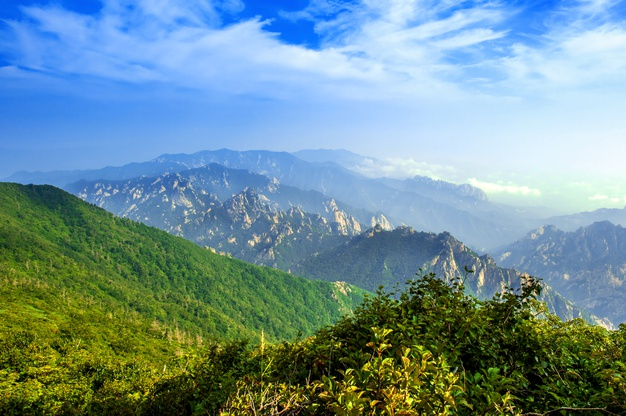

In [129]:
# open with PIL
image_url ="https://cioviews.com/wp-content/uploads/2020/12/2-2.jpg"
urllib.request.urlretrieve(image_url, "test.png") 
img = Image.open("test.png")
img

In [5]:
from IPython.display import display
from IPython.display import Markdown
import textwrap

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [11]:
# alternative
from IPython.display import Image
from IPython.core.display import HTML
img = Image('test.jpg')
#img = Image(url="https://cioviews.com/wp-content/uploads/2020/12/2-2.jpg") # does not work with vison model

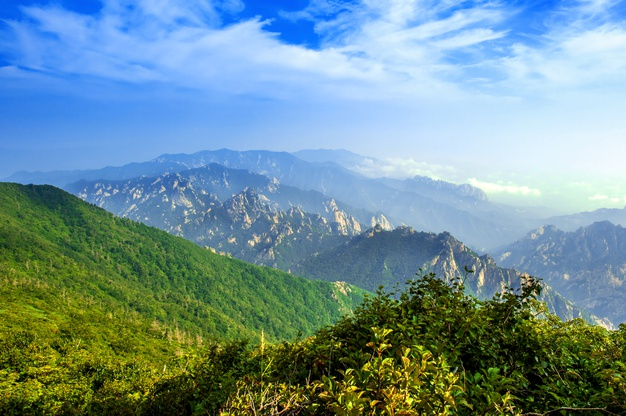

In [159]:
img

In [12]:
# Multimodal model
#import PIL.Image
#img = PIL.Image.open("test.png")
model = genai.GenerativeModel('gemini-pro-vision')
response = model.generate_content(img)

In [13]:
to_markdown(response.text)

>  The mountain range is called the Taebaek Mountains. The Taebaek Mountains are a mountain range in South Korea that stretch for about 500 kilometers (311 miles) from the north to the south of the country. The mountains are mostly made up of granite and are covered in forests. The highest peak in the range is Seoraksan, which is 1,708 meters (5,604 feet) high. The Taebaek Mountains are a popular destination for hiking and other outdoor activities.

In [25]:
# Multimodal model w/ langchain
from PIL import Image
img = Image.open("test.png")

llm = ChatGoogleGenerativeAI(model="gemini-pro-vision", temperature=0.2)
# example
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "What's in this image?",
        },  # You can optionally provide text parts
        {"type": "image_url", "image_url": { "url": "https://cioviews.com/wp-content/uploads/2020/12/2-2.jpg"} }, # img  
    ]
)

In [27]:
to_markdown(llm.invoke([message]).content)

>  The image shows a mountain range. The mountains are covered in trees and the sky is blue with white clouds.

## Data Ingestion (pdf)

In [22]:
#!pip install "unstructured[all-docs]" chromadb pydantic lxml tiktoken

In [6]:
#!pip install pytesseract

**Extract tables and images using ## unstructured**

install poppler and tesseract

In [1]:
from unstructured.partition.pdf import partition_pdf
import pytesseract

C:\Users\manth\anaconda3\envs\rag_langchain\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pytesseract.pytesseract.tesseract_cmd = r'D:\Manthan_Shenoy\Manthan_new\projects\projects-NLP\multimodal-rag-gemini\Tesseract-OCR\tesseract.exe'

In [3]:
image_path = "./"
pdf_elements = partition_pdf(
    "test.pdf",
    chunking_strategy="by_title",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    max_characters=3000,
    new_after_n_chars=2800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=image_path
    )

config.json: 100%|█████████████████████████████████████████████████████████████████| 1.47k/1.47k [00:00<00:00, 958kB/s]
model.safetensors: 100%|████████████████████████████████████████████████████████████| 115M/115M [00:01<00:00, 84.7MB/s]
model.safetensors: 100%|██████████████████████████████████████████████████████████| 46.8M/46.8M [00:00<00:00, 77.3MB/s]
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining

tables and texts into different groups

In [4]:
# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    text_elements = []
    table_elements = []
    for element in raw_pdf_elements:
        if 'CompositeElement' in str(type(element)):
            text_elements.append(str(element))
        elif 'Table' in str(type(element)):
            table_elements.append(str(element))
    return text_elements, table_elements


In [5]:
# extract tables and texts
texts, tables = categorize_elements(pdf_elements)

# length of text elem
print(len(texts))

# length of table elem
print(len(tables))

44
14


In [8]:
#texts

In [10]:
"""
import os
import base64
image_path = "./figures"
image_elements = []

# Function to encode images
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

for image_file in os.listdir(image_path):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        im_path = os.path.join(image_path, image_file)
        encoded_image = encode_image(im_path)
        image_elements.append(encoded_image)
        
# length of image elem
print(len(image_elements))
"""

6


### generate text, table and image summaries

In [26]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain.prompts import PromptTemplate

model = ChatGoogleGenerativeAI(model="gemini-pro",temperature=0, max_tokens=1024)
model_vision = ChatGoogleGenerativeAI(model="gemini-pro-vision",temperature=0, max_tokens=1024)

In [35]:
#texts[0:19]

['3 2 0 2\n\ny a M 3 2 ] G L . s c [\n\n1 v 4 1 3 4 1 . 5 0 3 2 : v i X r a\n\nQLORA: Efficient Finetuning of Quantized LLMs\n\nTim Dettmers∗\n\nArtidoro Pagnoni∗\n\nAri Holtzman\n\nLuke Zettlemoyer\n\nUniversity of Washington {dettmers,artidoro,ahai,lsz}@cs.washington.edu\n\nAbstract\n\nWe present QLORA, an efficient finetuning approach that reduces memory us- age enough to finetune a 65B parameter model on a single 48GB GPU while preserving full 16-bit finetuning task performance. QLORA backpropagates gradi- ents through a frozen, 4-bit quantized pretrained language model into Low Rank Adapters (LoRA). Our best model family, which we name Guanaco, outperforms all previous openly released models on the Vicuna benchmark, reaching 99.3% of the performance level of ChatGPT while only requiring 24 hours of finetuning on a single GPU. QLORA introduces a number of innovations to save memory without sacrificing performance: (a) 4-bit NormalFloat (NF4), a new data type that is information the

text & table summaries

In [36]:
# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well-optimized for retrieval. Table \
    or text: {element} """
    prompt = PromptTemplate.from_template(prompt_text)
    #empty_response = RunnableLambda(
      #  lambda x: AIMessage(content="Error processing document")
   # )
    # Text summary chain
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries


# Get text & table summaries
text_summaries, table_summaries = generate_text_summaries(texts[0:19], tables, summarize_texts=True)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


In [38]:
len(text_summaries)

19

In [39]:
table_summaries

['- Elo: 1348 ± 1\n- GPT-4 Guanaco 65B: 41 GB, 1022 ± 1\n- Guanaco 33B: 21 GB, 974 ± 1\n- Vicuna 13B: 26 GB, 966 ± 1\n- ChatGPT: 916 ± 1\n- Guanaco 13B: 10 GB, 902 ± 1\n- Bard: 879 ± 1\n- Guanaco 7B: 6 GB, -',
 '- Table compares performance of various models on GLUE and Super-NaturalInstructions tasks.\n- Models include RoBERTa-large, T5 variants, and LoRA.\n- Metrics include accuracy (Acc.) and RougeL.\n- T5-11B achieves highest accuracy on GLUE and Super-NaturalInstructions tasks.\n- LoRA models show competitive performance, especially with quantization techniques like BF16, Int8, FP4, and NF4.',
 'Table presents mean PPL values for different data types: Int4, Float4 (E2M1), Float4 (E3M0), and NFloat4 + DQ. Int4 has the highest mean PPL of 34.34, followed by Float4 (E2M1) at 31.07, Float4 (E3M0) at 29.48, and NFloat4 + DQ with the lowest mean PPL of 27.41.',
 '- Table presents mean 5-shot MMLU accuracy for various LLaMA model sizes and datasets.\n- Accuracy generally increases with l

image summaries

In [29]:
import os
import base64
# encode image
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [31]:
def image_summarize(img_base64, prompt):
    """Make image summary"""
    msg = model_vision.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


In [32]:
def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """
    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


In [33]:
fpath = "./figures"
# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [34]:
image_summaries

[' The image is a scatter plot. The x-axis is labeled "LoRa r" and the y-axis is labeled "Rouge L". There are four sets of data points, each represented by a different color. The data points are distributed in a roughly linear fashion.',
 " Response A is a bit short and doesn't really give any specific examples of technological advancements. Response B is much more detailed and gives several specific examples. I would rate Response B higher because it is more informative and gives a better idea of what the future might hold.",
 ' The image shows a bar chart comparing the performance of different sized language models on a variety of tasks. The largest model, a 65B model, performs the best on all tasks. The smallest model, a 7B model, performs the worst on all tasks.',
 ' The image shows three different ways to quantize a transformer model for low-precision training. The first, Full Finetuning, does not use adapters and has 32-bit optimizer states, while the second, LoRA, uses adapters 

## Multi-vector retriever

* add raw docs and summaries to Multi-vector Retriever
* retrieve original raw documents (texts, tables & images) from *docstore* corresponding to the retrieved vector from  *vectorstore*

In [40]:
import uuid
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

In [41]:
def create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """
    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )
    
    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever



In [42]:
# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_gemini",
    embedding_function=GoogleGenerativeAIEmbeddings(model="models/embedding-001"), # embedding model  
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

## RAG Pipeline


In [43]:
import io
import re

from IPython.display import HTML, display
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    if len(b64_images) > 0:
        return {"images": b64_images[:1], "texts": []}
    return {"images": b64_images, "texts": texts}
  


In [44]:
def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an AI scientist tasking with providing factual answers from research papers.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide answers related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)
    return [HumanMessage(content=messages)]

def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model_vision  # MM_LLM
        | StrOutputParser()
    )

    return chain

In [45]:
# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

examine retrieval

In [75]:
query = """How does QLORA  differ from LORA and Full-finetuned model? Explain it in detail"""
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=1)

In [47]:
len(docs)

4

In [79]:
split_image_text_types(docs)

Processing document: For our second setup, since full finetuning models at and beyond 11B parameters requires more than one server of high memory GPUs, we continue to test whether 4-bit QLORA can match 16-bit LoRA at the 7B to 65B parameter scales. To this end, we finetune LLaMA 7B through 65B on two instruction following datasets, Alpaca and FLAN v2, and evaluate on the MMLU benchmark via 5-shot accuracy. Results are shown in Table 4 where we see that NF4 with double quantization fully recovers the 16-bit LoRA MMLU performance. In addition, we also note that QLORA with FP4 lags behind the 16-bit brain float LoRA baseline by about 1 percentage point. This corroborates both our findings that (1) QLORA with NF4 replicates both 16-bit full finetuning and 16-bit LoRA finetuning performance, and (2) NF4 is superior to FP4 in terms of quantization precision.

Summary Our results consistently show that 4-bit QLORA with NF4 data type matches 16- bit full finetuning and 16-bit LoRA finetuning p

{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJYBRQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA

In [77]:
docs[0]

'For our second setup, since full finetuning models at and beyond 11B parameters requires more than one server of high memory GPUs, we continue to test whether 4-bit QLORA can match 16-bit LoRA at the 7B to 65B parameter scales. To this end, we finetune LLaMA 7B through 65B on two instruction following datasets, Alpaca and FLAN v2, and evaluate on the MMLU benchmark via 5-shot accuracy. Results are shown in Table 4 where we see that NF4 with double quantization fully recovers the 16-bit LoRA MMLU performance. In addition, we also note that QLORA with FP4 lags behind the 16-bit brain float LoRA baseline by about 1 percentage point. This corroborates both our findings that (1) QLORA with NF4 replicates both 16-bit full finetuning and 16-bit LoRA finetuning performance, and (2) NF4 is superior to FP4 in terms of quantization precision.\n\nSummary Our results consistently show that 4-bit QLORA with NF4 data type matches 16- bit full finetuning and 16-bit LoRA finetuning performance on acad

In [55]:
docs[1]

'For our second setup, since full finetuning models at and beyond 11B parameters requires more than one server of high memory GPUs, we continue to test whether 4-bit QLORA can match 16-bit LoRA at the 7B to 65B parameter scales. To this end, we finetune LLaMA 7B through 65B on two instruction following datasets, Alpaca and FLAN v2, and evaluate on the MMLU benchmark via 5-shot accuracy. Results are shown in Table 4 where we see that NF4 with double quantization fully recovers the 16-bit LoRA MMLU performance. In addition, we also note that QLORA with FP4 lags behind the 16-bit brain float LoRA baseline by about 1 percentage point. This corroborates both our findings that (1) QLORA with NF4 replicates both 16-bit full finetuning and 16-bit LoRA finetuning performance, and (2) NF4 is superior to FP4 in terms of quantization precision.\n\nSummary Our results consistently show that 4-bit QLORA with NF4 data type matches 16- bit full finetuning and 16-bit LoRA finetuning performance on acad

In [80]:
docs[2]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHVBDADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAo

In [57]:
docs[3]

'3 QLORA Finetuning\n\nQLORA achieves high-fidelity 4-bit finetuning via two techniques we propose—4-bit NormalFloat (NF4) quantization and Double Quantization. Additionally, we introduce Paged Optimizers, to prevent memory spikes during gradient checkpointing from causing out-of-memory errors that have traditionally made finetuning on a single machine difficult for large models.\n\nQLORA has one low-precision storage data type, in our case usually 4-bit, and one computation data type that is usually BFloat16. In practice, this means whenever a QLORA weight tensor is used, we dequantize the tensor to BFloat16, and then perform a matrix multiplication in 16-bit.\n\nWe now discuss the components of QLORA followed by a formal definition of QLORA.\n\n4-bit NormalFloat Quantization The NormalFloat (NF) data type builds on Quantile Quantization [15] which is an information-theoretically optimal data type that ensures each quantization bin has an equal number of values assigned from the input


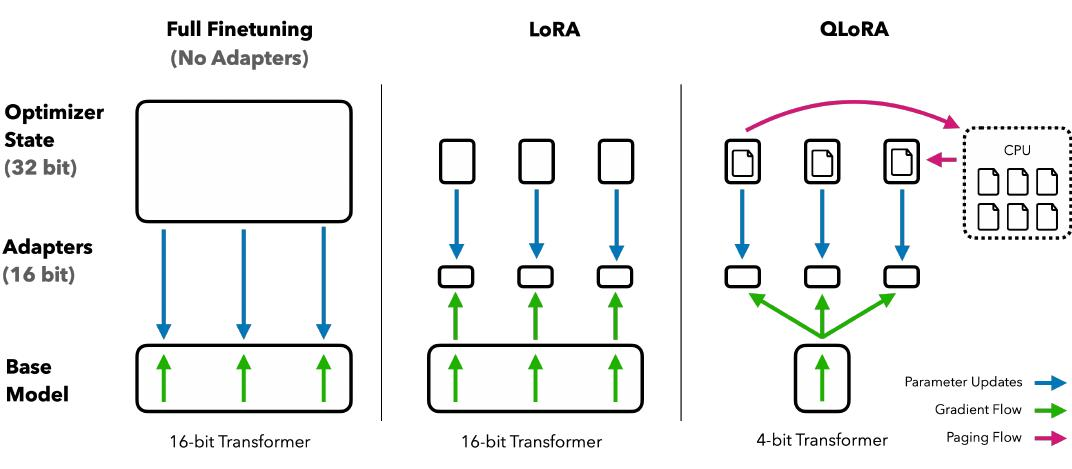

In [53]:
# We get back relevant images
plt_img_base64(docs[2])

### Final Result

In [60]:
chain_multimodal_rag.invoke(query)

' The image shows the differences between three different models: Full Finetuning, LORA, and QLORA.\n\nFull Finetuning is a model that is fine-tuned on a specific task. The model is trained on a large dataset of labeled data, and the weights of the model are adjusted to minimize the loss function on the training data. This model typically has good performance on the task it is fine-tuned on, but it may not generalize well to other tasks.\n\nLORA is a model that uses a low-rank adapter to fine-tune a large pretrained model. The adapter is a small, lightweight model that is trained on a specific task. The adapter is added to the pretrained model, and the weights of the adapter are adjusted to minimize the loss function on the training data. This model typically has good performance on the task it is fine-tuned on, and it can also generalize well to other tasks.\n\nQLORA is a model that uses a quantized low-rank adapter to fine-tune a large pretrained model. The adapter is a small, lightw

In [81]:
query = """How is 4-bit NormalFloat better than 4-bit Float when tested on LLaMA?"""
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=1)

In [82]:
docs[1]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFhAd0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKAMHxjLcRaAgtrma2klv7KAywkB1WS6iRsE5/hYj8ab/wjE3/Qya5/3/j/APiKPGX/ACA7b/sK6b/6Ww10FAHP/wDCMTf9DJrn/f8Aj/8AiKP+EYm/6GTXP+/8f/xFcV8UNY1DVrDWdM0a8mtbXRbRrvU


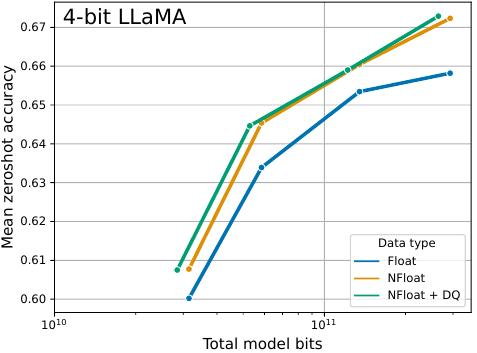

In [73]:
plt_img_base64(docs[1])

In [74]:
chain_multimodal_rag.invoke(query)

' The 4-bit NormalFloat is better than the 4-bit Float when tested on LLaMA because it achieves higher accuracy. This is shown in the graph, which shows the mean zero-shot accuracy of the different data types on the LLaMA task. The 4-bit NormalFloat achieves an accuracy of 0.67, while the 4-bit Float achieves an accuracy of 0.65. This difference in accuracy is statistically significant.'